In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams['text.color'] = 'white'

img_size, bsize = 512, 6

print(tf.__version__)

2.16.1


# Data Loading

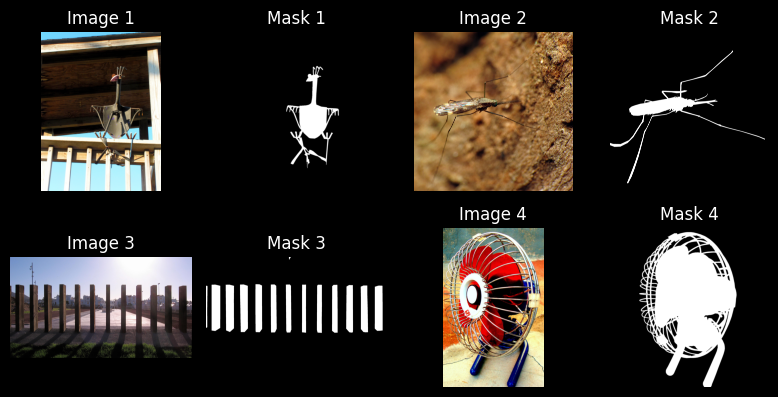

In [2]:
base_te1_subdir = '/kaggle/input/disk5-image-segmentation-ds/DIS5K/DIS-TR'
images_dir = os.listdir(base_te1_subdir + '/im')
x = 4

plt.figure(figsize=(8, 8), facecolor='black')
rand_idx = np.random.choice(len(images_dir), size=x, replace=False)
for i, idx in enumerate(rand_idx):
    image_path = base_te1_subdir + '/im/' + images_dir[idx]
    mask_path = (base_te1_subdir + '/gt/' + images_dir[idx]).replace('.jpg', '.png')
    
    image, mask = Image.open(image_path), Image.open(mask_path)
    
    plt.subplot(x, x, 2*i + 1)
    plt.imshow(image)
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
    plt.subplot(x, x, 2*i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask {i+1}')
    plt.axis('off')
    
plt.tight_layout()

In [3]:
from sklearn.model_selection import train_test_split

base_dir = '/kaggle/input/disk5-image-segmentation-ds/DIS5K'

mask_path, img_path = [], []
for d in os.listdir(base_dir):
    class_dir = os.path.join(base_dir + '/' + d + '/im')
    images_name = os.listdir(class_dir)
    for name in images_name:
        image_path = class_dir + '/' + name
        img_path.append(image_path)
        
        mask_p = image_path.replace('.jpg', '.png').replace('/im', '/gt')
        mask_path.append(mask_p)
        
train_img_path, val_img_path, train_mask_path, val_mask_path = train_test_split(
    img_path, mask_path, test_size=0.2, random_state=42, shuffle=True
)

print(f'train size: {len(train_img_path)}\nvalidation size: {len(val_mask_path)}')

train size: 4376
validation size: 1094


In [4]:
def load_image_and_mask(image_path, mask_path, img_size):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.math.scalar_mul(1.0/255, img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [img_size, img_size])
    mask = tf.math.scalar_mul(1.0/255, mask)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    return img, mask

In [5]:
def load_dataset(img_paths, mask_paths, batch_size, img_size=128, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(img_paths), reshuffle_each_iteration=True)
    
    ds = ds.map(lambda img, mask: load_image_and_mask(img, mask, img_size), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = load_dataset(train_img_path, train_mask_path, batch_size=bsize, img_size=img_size, shuffle=True)
val_ds = load_dataset(val_img_path, val_mask_path, batch_size=bsize, img_size=img_size, shuffle=False)

train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>

(512, 512, 3) (512, 512, 1)


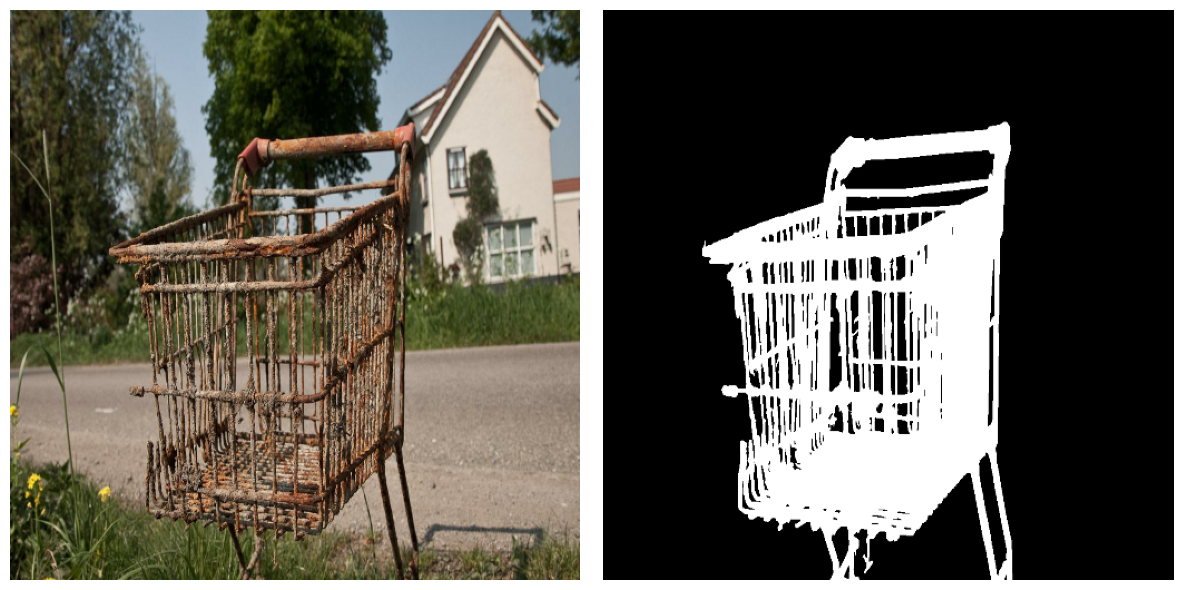

In [6]:
index = np.random.randint(0, bsize)

for images, masks in train_ds.take(1):
    image = images[index].numpy()
    mask = masks[index].numpy() 
    print(image.shape, mask.shape)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image)
    ax1.axis('off')
    
    ax2.imshow(mask[:,:,0], cmap='gray')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# U2-Net Model Definition

In [7]:
def conv_block(inputs, out_ch, rate=1):
    x = keras.layers.Conv2D(out_ch, 3, padding="same", dilation_rate=rate)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    return x


#RSU L
def RSU_Block(x, out_channels, intermediate_channels, n_layers, rate=2):
    skip=[]
    
    x = conv_block(x, out_channels)
    original_features = x
    
    #Encoder
    x = conv_block(x, intermediate_channels)
    skip.append(x)
    
    for i in range(n_layers-2):
        x = keras.layers.MaxPool2D((2, 2))(x)
        x = conv_block(x, intermediate_channels)
        skip.append(x)
        
    #Bridge
    x = conv_block(x, intermediate_channels, rate=rate)
    
    #Decoder
    skip.reverse()
    x = keras.layers.Concatenate()([x, skip[0]])
    x = conv_block(x, intermediate_channels)
    
    for i in range(n_layers-3):
        x = keras.layers.UpSampling2D(size = (2,2), interpolation='bilinear')(x)
        x = keras.layers.Concatenate()([x, skip[i+1]])
        x = conv_block(x, intermediate_channels)
        
    x = keras.layers.UpSampling2D(size = (2,2), interpolation='bilinear')(x)
    x = keras.layers.Concatenate()([x, skip[-1]])
    x = conv_block(x, out_channels)
    
    y = keras.layers.Add()([x, original_features])
    return y

In [8]:
def RSU_Middle_Block(x, out_channels, intermediate_channels):
    x0 = conv_block(x, intermediate_channels, rate=1)
    
    x1 = conv_block(x0, intermediate_channels, rate=1)
    x2 = conv_block(x1, intermediate_channels, rate=2)
    x3 = conv_block(x2, intermediate_channels, rate=4)
    
    x4 = conv_block(x3, intermediate_channels, rate=8)
    
    x = keras.layers.Concatenate()([x4, x3])
    x = conv_block(x, intermediate_channels, rate=4)
    
    x = keras.layers.Concatenate()([x, x2])
    x = conv_block(x, intermediate_channels, rate=2)
    
    x = keras.layers.Concatenate()([x, x1])
    x = conv_block(x, intermediate_channels, rate=1)
    
    y = keras.layers.Add()([x, x0])
    return y

In [9]:
from keras.models import Model

input_shape = (img_size, img_size, 3)
def u2net(input_shape):
    inputs = keras.layers.Input(input_shape)
    s0 = inputs
    
    #Encoder Path
    s1 = RSU_Block(x=s0, out_channels=64, intermediate_channels=32, n_layers=7)
    p1 = keras.layers.MaxPooling2D((2, 2))(s1)
    
    s2 = RSU_Block(x=p1, out_channels=128, intermediate_channels=32, n_layers=6)
    p2 = keras.layers.MaxPooling2D((2, 2))(s2)
    
    s3 = RSU_Block(x=p2, out_channels=256, intermediate_channels=64, n_layers=5)
    p3 = keras.layers.MaxPooling2D((2, 2))(s3)
    
    s4 = RSU_Block(x=p3, out_channels=512, intermediate_channels=128, n_layers=4)
    p4 = keras.layers.MaxPooling2D((2, 2))(s4)
   
    s5 = RSU_Middle_Block(p4, out_channels=512, intermediate_channels=256)
    p5 = keras.layers.MaxPooling2D((2, 2))(s5)
    print(f'last encoder rsu block layer shape: {s5.shape}')
    
    #Bridge
    b1 = RSU_Middle_Block(p5, out_channels=512, intermediate_channels=256)
    b2 = keras.layers.UpSampling2D(size=2, interpolation='bilinear')(b1)
    print(f'bridge shape: {b2.shape}')
    
    #Decoder
    d1 = keras.layers.Concatenate()([b2, s5])
    d1 = RSU_Middle_Block(d1, out_channels=512, intermediate_channels=256)
    up1 = keras.layers.UpSampling2D(size=2, interpolation='bilinear')(d1)
    
    d2 = keras.layers.Concatenate()([up1, s4])
    d2 = RSU_Block(d2, out_channels=256, intermediate_channels=128, n_layers=4)
    up2 = keras.layers.UpSampling2D(size=2, interpolation='bilinear')(d2)
    
    d3 = keras.layers.Concatenate()([up2, s3])
    d3 = RSU_Block(d3, out_channels=128, intermediate_channels=64, n_layers=5)
    up3 = keras.layers.UpSampling2D(size=2, interpolation='bilinear')(d3)
    
    d4 = keras.layers.Concatenate()([up3, s2])
    d4 = RSU_Block(d4, out_channels=64, intermediate_channels=32, n_layers=6)
    up4 = keras.layers.UpSampling2D(size=2, interpolation='bilinear')(d4)
    
    d5 = keras.layers.Concatenate()([up4, s1])
    d5 = RSU_Block(d5, out_channels=64, intermediate_channels=16, n_layers=7)
    print(f'last decoder rsu block layer shape: {d5.shape}')
    
    #Side Output
    side_1 = keras.layers.Conv2D(filters=1, kernel_size=3, padding="same", strides=1)(d5)
    
    side_2 = keras.layers.Conv2D(filters=1, kernel_size=3, padding="same", strides=1)(d4)
    side_2 = keras.layers.UpSampling2D(size=2, interpolation='bilinear')(side_2)
    
    side_3 = keras.layers.Conv2D(filters=1, kernel_size=3, padding="same", strides=1)(d3)
    side_3 = keras.layers.UpSampling2D(size=4, interpolation='bilinear')(side_3)
    
    side_4 = keras.layers.Conv2D(filters=1, kernel_size=3, padding="same", strides=1)(d2)
    side_4 = keras.layers.UpSampling2D(size=8, interpolation='bilinear')(side_4)
    
    side_5 = keras.layers.Conv2D(filters=1, kernel_size=3, padding="same", strides=1)(d1)
    side_5 = keras.layers.UpSampling2D(size=16, interpolation='bilinear')(side_5)
    
    side_6 = keras.layers.Conv2D(filters=1, kernel_size=3, padding="same", strides=1)(b1)
    side_6 = keras.layers.UpSampling2D(size=32, interpolation='bilinear')(side_6)
    
    print(f'side_1 shape:{side_1.shape}')
    print(f'side_2 shape:{side_2.shape}')
    print(f'side_3 shape:{side_3.shape}')
    print(f'side_4 shape:{side_4.shape}')
    print(f'side_5 shape:{side_5.shape}')
    print(f'side_6 shape:{side_6.shape}')
    
    fusion = keras.layers.Concatenate()([side_1, side_2, side_3, side_4, side_5, side_6])
    fusion_conv = keras.layers.Conv2D(filters=1, kernel_size=3, padding="same")(fusion)
    
    #Activation Functions
    side_1 = keras.layers.Activation("sigmoid")(side_1)
    side_2 = keras.layers.Activation("sigmoid")(side_2)
    side_3 = keras.layers.Activation("sigmoid")(side_3)
    side_4 = keras.layers.Activation("sigmoid")(side_4)
    side_5 = keras.layers.Activation("sigmoid")(side_5)
    side_6 = keras.layers.Activation("sigmoid")(side_6)
    fusion_conv = keras.layers.Activation("sigmoid")(fusion_conv)
    
    model = Model(inputs=inputs, outputs=[fusion_conv, side_1, side_2, side_3, side_4, side_5, side_6])
    return model
    

In [10]:
model = u2net(input_shape)

last encoder rsu block layer shape: (None, 32, 32, 256)
bridge shape: (None, 32, 32, 256)
last decoder rsu block layer shape: (None, 512, 512, 64)
side_1 shape:(None, 512, 512, 1)
side_2 shape:(None, 512, 512, 1)
side_3 shape:(None, 512, 512, 1)
side_4 shape:(None, 512, 512, 1)
side_5 shape:(None, 512, 512, 1)
side_6 shape:(None, 512, 512, 1)


In [11]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
)

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     18,464 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      9,248 │ max_pooling2d_2[

 Total params: 31,640,125 (120.70 MB)

 Trainable params: 31,614,397 (120.60 MB)

 Non-trainable params: 25,728 (100.50 KB)

# Model Callbacks

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

base_model_path = '/kaggle/working/u2net_segmentation_'

model_p = base_model_path + 'model.keras'
weights_p = base_model_path + 'weights.weights.h5'

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1
)

early = EarlyStopping(
            monitor="val_loss",
            patience=15, 
            verbose=1,
            mode="min", 
            restore_best_weights=True)

model_checkpoint = ModelCheckpoint(model_p, 
                                   monitor = "val_loss",
                                   mode = "min",
                                   verbose=1,
                                   save_best_only=True, 
                                   save_weights_only=False)

weights_checkpoint = ModelCheckpoint(weights_p, 
                                    monitor = "val_loss",
                                    mode = "min",
                                    save_best_only=True, 
                                    save_weights_only=True)



cb = [early, model_checkpoint, weights_checkpoint, reduce_lr]

# U2-Net Fit

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=cb,
    verbose=1
)

Epoch 1/100


I0000 00:00:1728263705.938921      69 service.cc:145] XLA service 0x7d96e0002550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728263705.938992      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728263705.938997      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728263870.827770      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


730/730 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4069
Epoch 1: val_loss improved from inf to 0.37619, saving model to /kaggle/working/u2net_segmentation_model.keras
730/730 ━━━━━━━━━━━━━━━━━━━━ 1464s 2s/step - loss: 0.4069 - val_loss: 0.3762 - learning_rate: 1.0000e-04
Epoch 2/100
730/730 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3393
Epoch 2: val_loss improved from 0.37619 to 0.35045, saving model to /kaggle/working/u2net_segmentation_model.keras
730/730 ━━━━━━━━━━━━━━━━━━━━ 1120s 2s/step - loss: 0.3393 - val_loss: 0.3504 - learning_rate: 1.0000e-04
Epoch 3/100
730/730 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3052
Epoch 3: val_loss improved from 0.35045 to 0.30753, saving model to /kaggle/working/u2net_segmentation_model.keras
730/730 ━━━━━━━━━━━━━━━━━━━━ 1120s 2s/step - loss: 0.3052 - val_loss: 0.3075 - learning_rate: 1.0000e-04
Epoch 4/100
730/730 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2839
Epoch 4: val_loss did not improve from 0.30753
730/730 ━━━━━━━━━━━━━━━━━━━━ 1116s 2s/ste

In [15]:
path = "/kaggle/working/"
model.save(path + "u2net-512.keras")